# Apply a trained model and export predictions for analysis

In [77]:
#dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smpu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import cv2
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from torchvision.ops import masks_to_boxes
from matplotlib.patches import Rectangle
import numpy as np
import albumentations as albu

In [78]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #Select GPU
path_book = '/scratch/ndillenb/extract_skematic/all_images' #Folder with all extracted illustrations
book = ''#'test_books'
path_model = '/scratch/ndillenb/trained_model_saved/UnetPlusPlus/resnext101_32x8d/instagram/Jaccard_Loss/half_split_test_val_distribution(50-3-3)-(80-10-10)/batch32_size160_epoch4256_lr_1.09E-05/best_model.pth'
TRAIN_ON_160 = True #If model has be trained on images of size 160x160
ENCODER = 'resnext101_32x8d' #Encoder used in path_model
ENCODER_WEIGHTS = 'instagram' #Weights used for training
CLASSES = ['hand'] #Classes used
DEVICE = 'cuda'
best_model = torch.load(path_model)

In [79]:
#Define a class
class Reclangle:
    def __init__(self,x,y,w,h,conf):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.conf = conf
    def data(self):
        return [self.x,self.y],self.w,self.h,self.conf

#helper function used to visualize predictions
def visualize(boxes,image,mask,contours):
    fig, ax = plt.subplots()
    for box in boxes:
        ax.text(box.data()[0][0],box.data()[0][1],'conf '+ str(box.data()[3]),color='green')
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    for contour in contours:
        contour_points = np.array(contour).reshape(-1, 2)
        x = contour_points[:, 0]
        y = contour_points[:, 1]
        plt.plot(x, y, color='red')
    plt.imshow(image)
    plt.show()
    fig, ax = plt.subplots()
    for box in boxes:
        ax.text(box.data()[0][0],box.data()[0][1],'conf '+ str(box.data()[3]),color='green')
    plt.xticks([])
    plt.yticks([])
    for contour in contours:
        contour_points = np.array(contour).reshape(-1, 2)
        x = contour_points[:, 0]
        y = contour_points[:, 1]
        # Plot the contour
        plt.plot(x, y, color='red')
    plt.title('Mask')
    plt.imshow(mask)
    plt.show()
#Transformation function for the dataset    
def get_apply_transform():
    if TRAIN_ON_160:
        test_transform = [
            albu.LongestMaxSize(max_size=160, interpolation=1, always_apply=True, p=1),
            albu.PadIfNeeded(min_height=160,min_width=160,always_apply=True, border_mode=1),
        ]
    else:
            test_transform = [
            albu.LongestMaxSize(max_size=480, interpolation=1, always_apply=True, p=1),
            albu.PadIfNeeded(min_height=None,min_width=None,pad_height_divisor=32,pad_width_divisor=32,always_apply=True, border_mode=1),
        ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

## Prepare the data to be processed

In [80]:
class Dataset(BaseDataset):
    CLASSES = ['__BACKGROUND__', 'hand']
    def __init__(self, 
        images_dir,  
        classes=None, 
        transform=None, 
        preprocessing=None,):
        self.root = path_book
        self.folder = book
    
        self.ids = list(sorted(os.listdir((os.path.join(self.root, images_dir)))))
        self.images_fps = list(sorted(os.listdir(os.path.join(self.root, images_dir))))
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.transform = transform
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.folder, self.images_fps[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply transform
        if self.transform:
            sample = self.transform(image=image)
            image = sample['image']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image

    def __len__(self):
        return len(self.ids)

In [81]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
apply_dataset = Dataset(
    book,
    transform=get_apply_transform(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
apply_loader = DataLoader(apply_dataset, batch_size=1, shuffle=False, num_workers=1)

### Save metadata for traceability

In [82]:
data_run = {'folder': path_book, 'model':path_model, 'items_len':len(apply_loader), 'train_on_160':TRAIN_ON_160}
print(data_run)

{'folder': '/scratch/ndillenb/extract_skematic/all_images', 'model': '/scratch/ndillenb/trained_model_saved/UnetPlusPlus/resnext101_32x8d/instagram/Jaccard_Loss/half_split_test_val_distribution(50-3-3)-(80-10-10)/batch32_size160_epoch4256_lr_1.09E-05/best_model.pth', 'items_len': 166295, 'train_on_160': True}


### Define your run id and threshold
* Run id is so that you don't rewrite on old predictions
* Threshold is the confidence level for which you want to show the prediction. This is simply so you can see while predicting, images with a high confidence. Using a too low threshold will slow the process

In [83]:
run = 25 #here it's our 25th run
THRESHOLD = 0.2
threshold_true=0.001 #define background values, should be small but can be higher if background is too noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


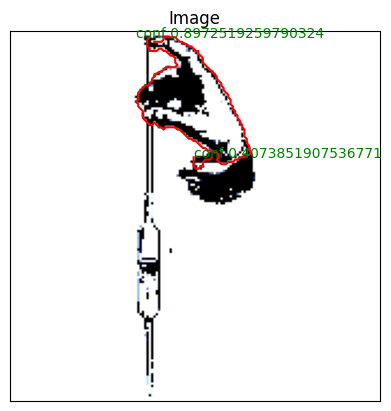

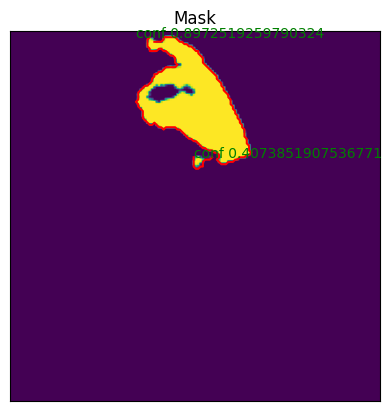

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


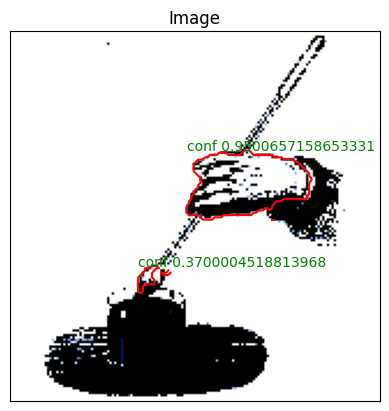

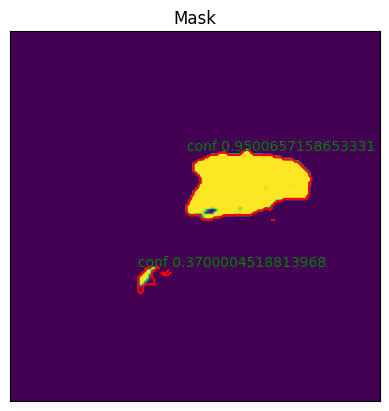

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


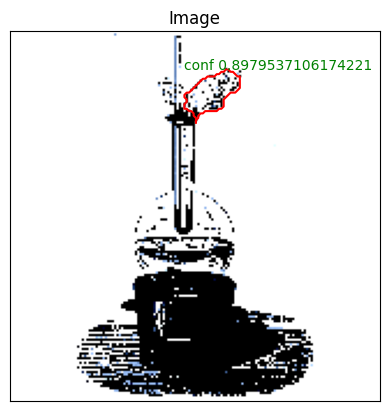

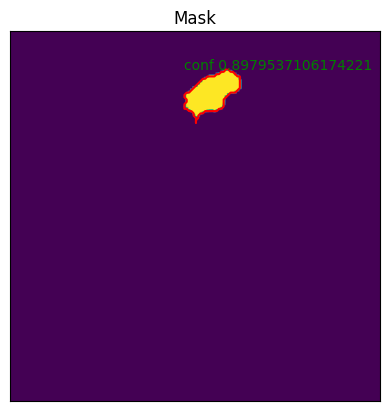

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


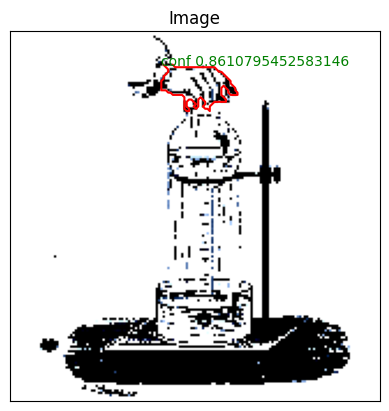

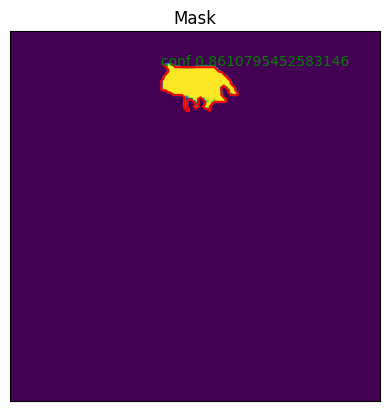

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


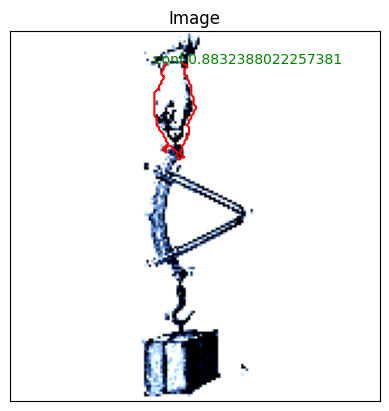

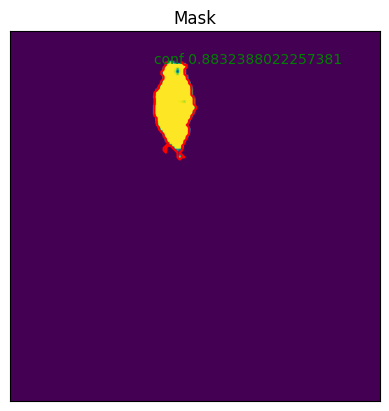

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


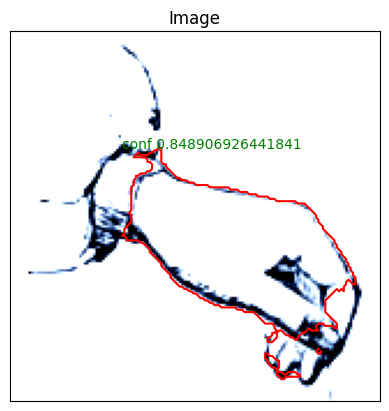

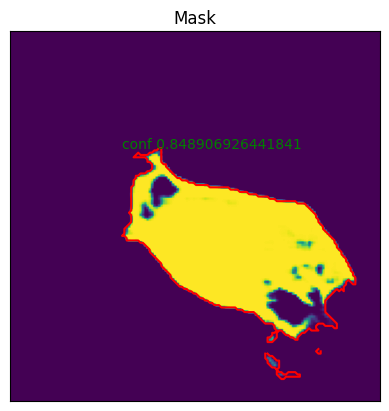

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


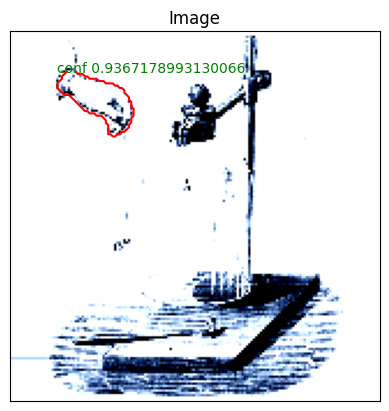

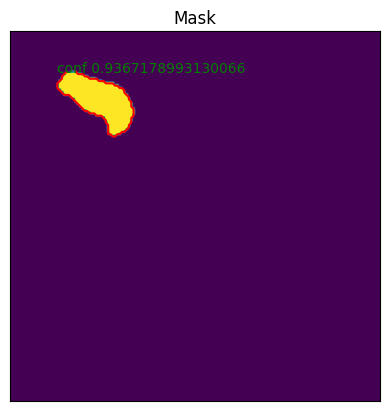

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


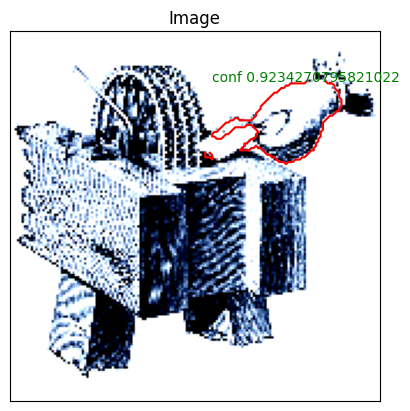

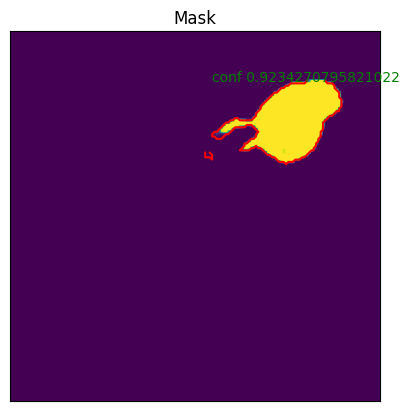

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


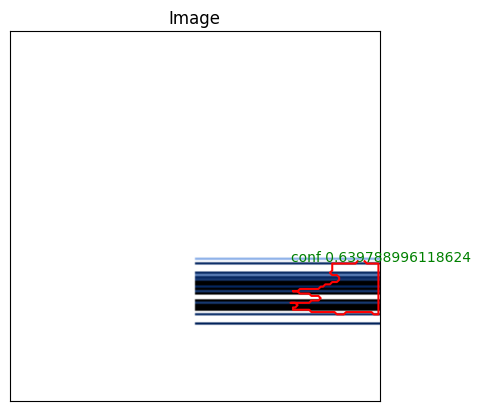

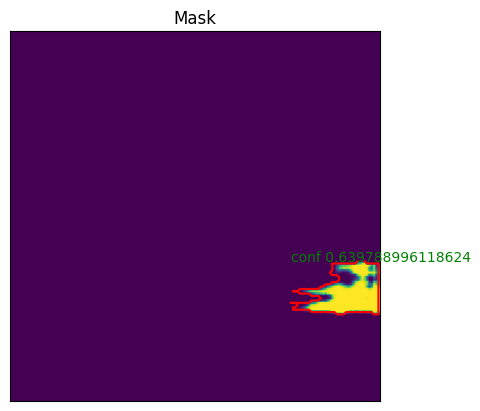

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


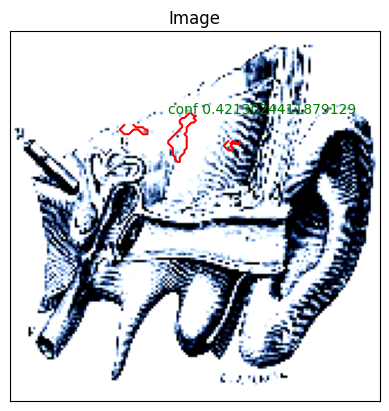

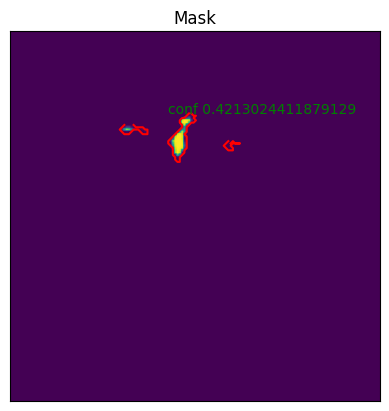

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


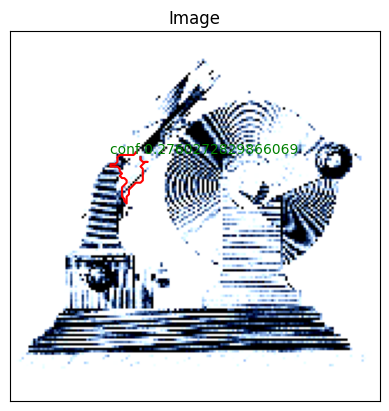

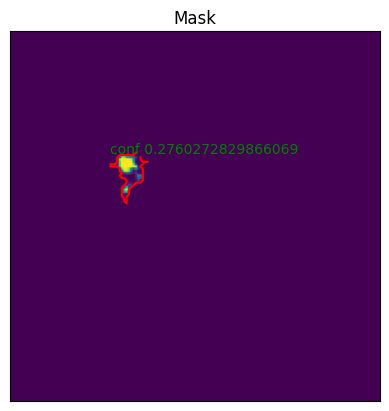

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


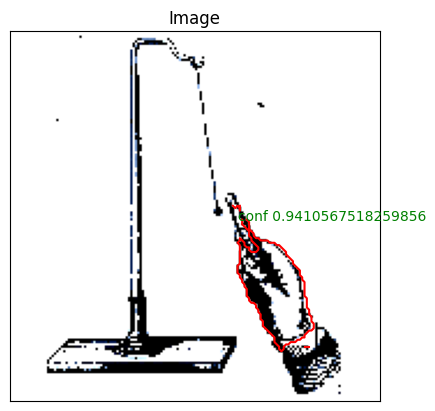

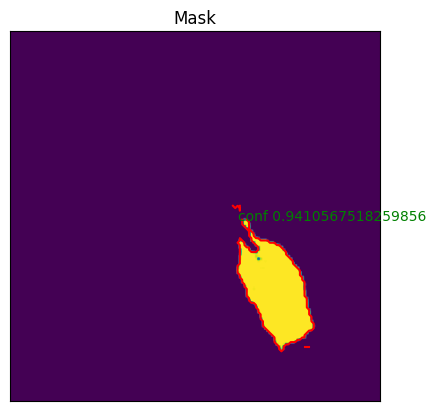

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


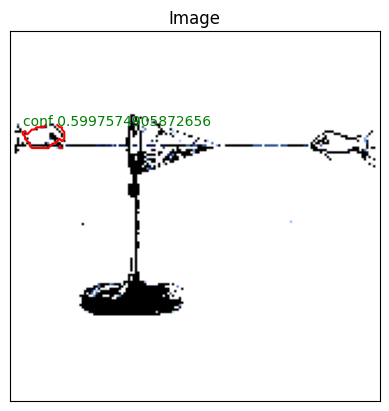

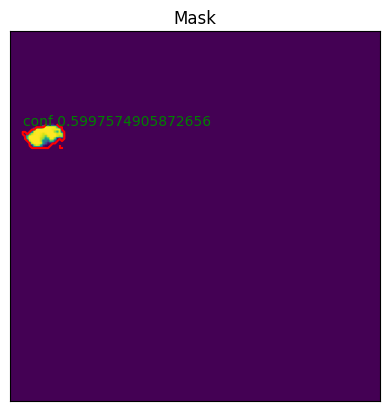

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


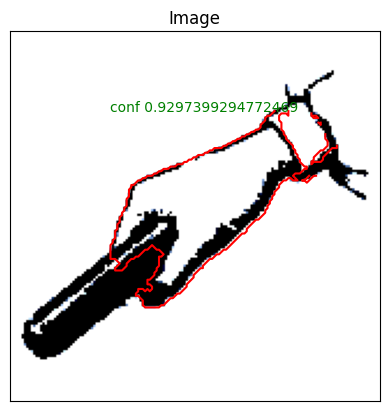

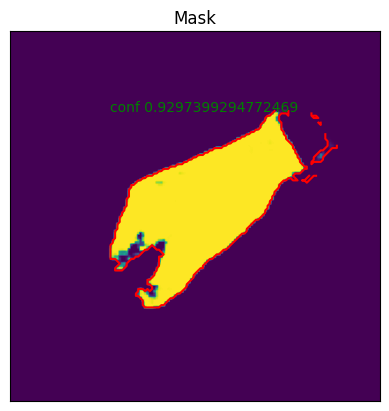

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


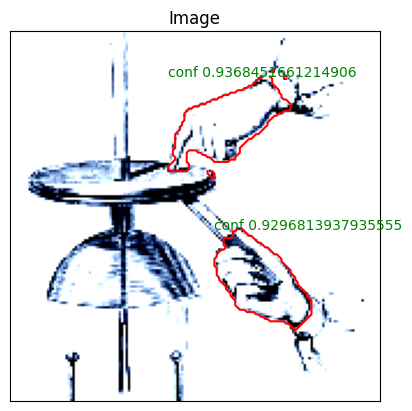

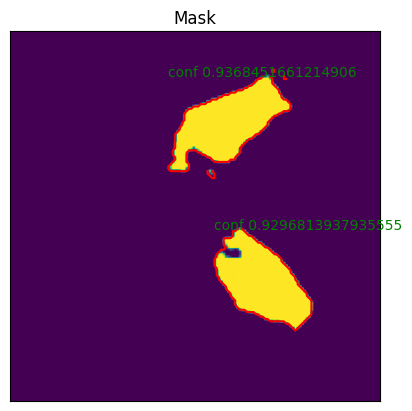

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


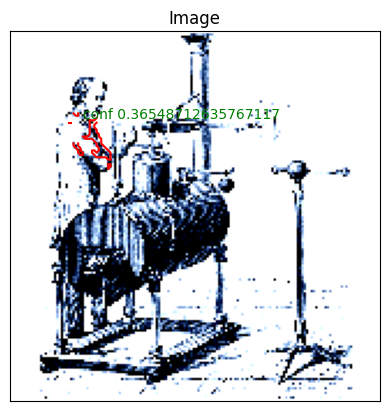

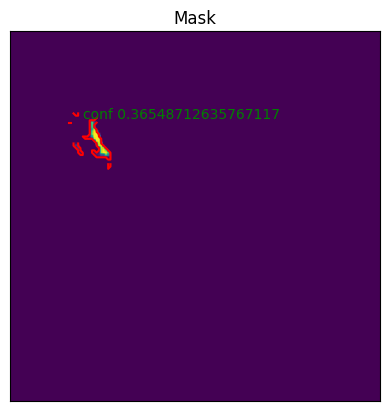

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


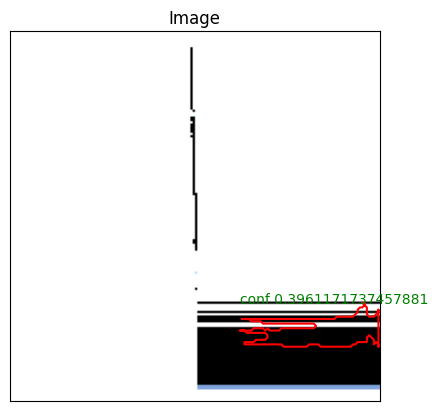

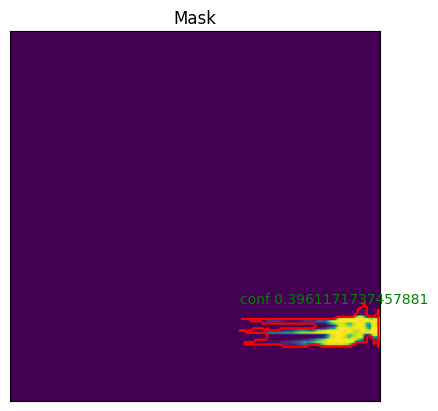

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


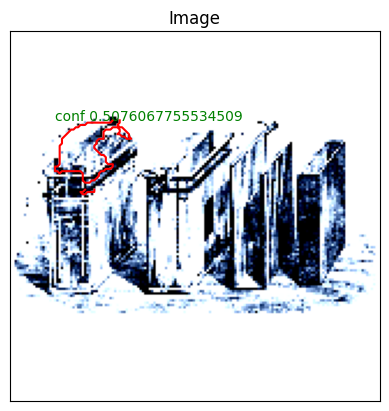

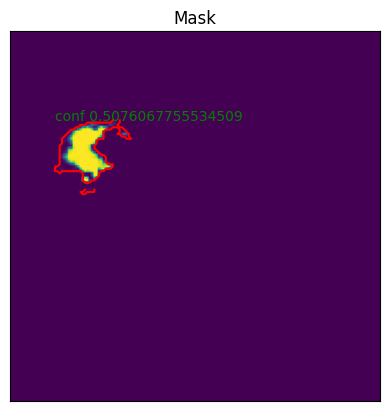

In [ ]:
os.makedirs('run_applied/run'+str(run),exist_ok=True) #create folder for storing predictions data
results = []
#temporary variables
i,j,t,f = 0,0,0,0
#Save metadata to run folder
name = 'run_applied/run'+str(run)+'/data_batch.pickle'
with open(name, 'wb') as handle:
    pickle.dump(data_run, handle, protocol=pickle.HIGHEST_PROTOCOL)
results = []
#iterate through images and predict
for image in apply_loader.dataset:    
    prediction = torch.from_numpy(image).to(DEVICE).unsqueeze(0)#Get prediction
    pr_mask = best_model.predict(prediction)
    pr_mask  = pr_mask.to(DEVICE)
    conf_np = pr_mask[0][0].cpu().numpy()#Build a confidence map
    binary_image = np.uint8(conf_np>threshold_true)#Turn all values but background to TRUE
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#Find contour
    opened_image = torch.from_numpy(binary_image).float().unsqueeze(0)
    boxes, all_boxes, all_conf= [],[],[]
    if len(contours) > 0: #if object is detected -> calculate confidence
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            mask_tmp = np.zeros_like(binary_image)
            cv2.fillPoly(mask_tmp, pts = [contour], color=255) #generate mask from contour
            mean_value, _, _, _ = cv2.mean(conf_np, mask=mask_tmp) #calculate confidence in contour
            tmp = Reclangle(x,y,w,h,mean_value) #Create bbox if user prefer bbox over contours
            if mean_value > THRESHOLD: 
                boxes.append(tmp)
            all_conf.append(mean_value)
            all_boxes.append(tmp)
    current_result = {'image':apply_loader.dataset.images_fps[i], 'image_shape':image.shape,'contour': contours,'bbox' : all_boxes, 'confidence' : all_conf}
    results.append(current_result) #Aggregate results
    if ((i % 3000 == 0) or (i ==len(apply_loader)-1)): #Save a pickle file with new predictions every 3000 illustrations
        name = 'run_applied/run'+str(run)+'/batch' + str(f)+'.pickle'
        with open(name, 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        results = [] #Reset results
        f+=1
    i+=1
    if len(boxes)>0:
        j+=1
        visualize(boxes, image.transpose(1, 2, 0).astype('float'), conf_np, contours) #See predictions with high confidence > THRESHOLD
    del conf_np
    del prediction
    del pr_mask
print('Total of image : ' + str(i))
print('Total of image with hands detected with THRESHOLD : ' + str(j))
print('Total of hands detected : ' + str(t))
print('Percentage of detection by image ' + str((j/i)*100) + ' %')